In [ ]:
# %pip install diffusers["torch"] transformers
# %pip install torchmetrics

In [ ]:
# This mounts your Google Drive to the Colab VM.
# from google.colab import drive
# drive.mount('/content/drive')
# FOLDERNAME = 'stanford/cs231n/cs231n_project/'
# assert FOLDERNAME is not None, "[!] Enter the foldername."
# import sys
# sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import matplotlib.pyplot as plt


import torchvision.datasets as dset
from torchvision.datasets import MNIST, CIFAR10
import torchvision.transforms as T
import torchvision.transforms as transforms
import torchvision.transforms.functional
from torchvision.transforms import v2
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim import AdamW
from tqdm import tqdm
import math
import torch.nn.functional as F

import numpy as np
from torchmetrics.image.inception import InceptionScore

import ddpm
import utils

/Users/lihenan/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# select device
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
elif torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
else:
    DEVICE = torch.device('cpu')
# DEVICE = torch.device('cpu')
print(f'{DEVICE=}')

# hyper param

DATASET = 'MNIST'  # CIFAR10 or MNIST
print(f'{DATASET=}')
if DATASET == 'MNIST':
    IMG_SIZE = (32, 32, 1) # original images are padded to make size 32 x 32
    DATASET = MNIST
elif DATASET == 'CIFAR10':
    IMG_SIZE = (32, 32, 3)
    DATASET = CIFAR10
print(f'{IMG_SIZE=}')

BATCH_SIZE = 64
N_LAYERS = 8
HIDDEN_DIM = 256
HIDDEN_DIMS = [HIDDEN_DIM for _ in range(N_LAYERS)]
N_TIMESTAMPS = 1000
TIMESTAMP_EMBED_DIM = 256
# BETA_MIN_MAX = [1e-4, 2e-2]
LEARNING_RATE = 5e-5
N_EPOCH = 2

# prepare data

dataset_path = './datasets'
transform = transforms.Compose([
    transforms.Resize(32), transforms.ToTensor()
])  # TODO: try subtract mean & div by std
train_dataset = DATASET(dataset_path, transform=transform,
                        train=True, download=True)
eval_dataset = DATASET(dataset_path, transform=transform,
                       train=True, download=True)
test_dataset = DATASET(dataset_path, transform=transform,
                       train=False, download=True)
NUM_DATASET = len(train_dataset)
NUM_DATASET = 1000  # use a smaller dataset
NUM_TRAIN = int(NUM_DATASET * 0.8)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
# train_sample = list(train_loader)[0][0]

print(train_dataset.data.type())
# print(train_dataset.data.float().mean(), train_dataset.data.min(), train_dataset.data.max(), train_dataset.data.shape)
# print(train_sample.mean(), train_sample.min(), train_sample.max(), train_sample.shape)

eval_loader = DataLoader(dataset=eval_dataset, batch_size=BATCH_SIZE,
                         sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_DATASET)))
test_loader = DataLoader(dataset=test_dataset,  batch_size=BATCH_SIZE)

N_CLASS = len(train_dataset.classes)
print(f'{N_CLASS=} {NUM_TRAIN=}')

DEVICE=device(type='mps')
DATASET='MNIST'
IMG_SIZE=(32, 32, 1)
torch.ByteTensor
N_CLASS=10 NUM_TRAIN=800


In [3]:
IMAGE_CHANNEL = IMG_SIZE[2]
eps_model = ddpm.UNet(
    image_channels=IMAGE_CHANNEL,
    n_channels=64,
    ch_mults=[1, 2, 2, 4],
    is_attn=[False, False, False, True],
).to(DEVICE)

diffusion = ddpm.DenoiseDiffusion(
    eps_model=eps_model,
    n_diffusion_timestep=N_TIMESTAMPS,
    device=DEVICE,
)

optimizer = Adam(eps_model.parameters(), lr=LEARNING_RATE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of model parameters:  170015425
forwarding diffusion sampling...
tensor(0.1268) tensor(0.) tensor(1.) torch.Size([64, 1, 32, 32])
tensor(0.0986, device='mps:0') tensor(-3.7386, device='mps:0') tensor(4.0416, device='mps:0') torch.Size([80, 1, 32, 32])


UNet(
  (image_proj): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_emb): TimeEmbedding(
    (lin1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (lin2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down): ModuleList(
    (0-1): 2 x DownBlock(
      (res): ResidualBlock(
        (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
        (act1): SiLU()
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
        (act2): SiLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (shortcut): Identity()
        (time_emb): Linear(in_features=256, out_features=64, bias=True)
        (time_act): SiLU()
        (class_emb): Linear(in_features=256, out_features=64, bias=True)
        (class_act): SiLU()
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (attn): Identity()
    )
    (2):

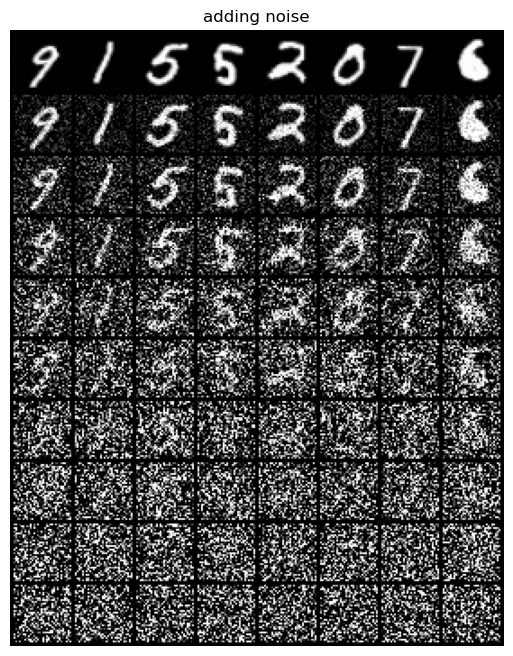

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of model parameters: ", count_parameters(eps_model))
print("forwarding diffusion sampling...")
eps_model.eval()
with torch.no_grad():
    for x, class_ in train_loader:
        print(x.mean(), x.min(), x.max(), x.shape)
        x = x[:8].to(DEVICE)
        xt = torch.tensor([]).to(DEVICE)
        for t in range(0, N_TIMESTAMPS, 100):
            xt = torch.cat((xt, diffusion.q(
                x, torch.full((8, ), t).to(DEVICE))))
        print(xt.mean(), xt.min(), xt.max(), xt.shape)
        utils.draw_sample_image(xt, f"adding noise")
        break  # only sample 1 batch
eps_model.train()


start training
training epoch=0


100%|██████████| 13/13 [00:21<00:00,  1.62s/it]


training epoch=1


100%|██████████| 13/13 [00:14<00:00,  1.08s/it]


Text(0.5, 1.0, 'training loss vs validation loss')

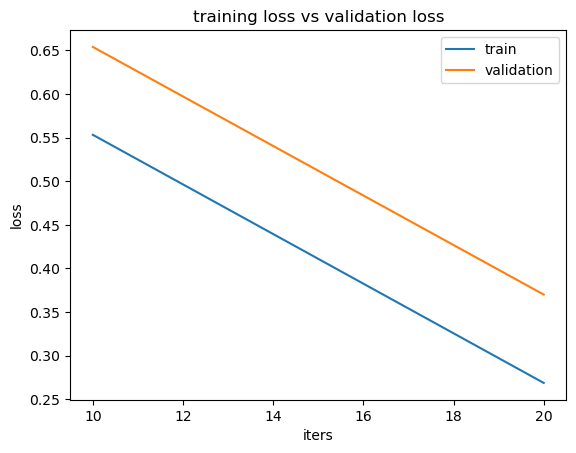

In [5]:
print("start training")

train_loss_arr = [0]
eval_loss_arr = [0]
iters = [0]

EVAL_EVERY_ITER = 10
EVAL_BATCH = 10

def evaluate():
    with torch.no_grad():
        eval_loss = 0.0
        train_loss = 0.0
        eps_model.eval()
        for train_batch_idx, (img_, class_) in enumerate(train_loader):
            train_loss += diffusion.loss(img_.to(DEVICE), class_.to(DEVICE)).item()
            if train_batch_idx > EVAL_BATCH:
                break
        for eval_batch_idx, (img_, class_) in enumerate(eval_loader):
            eval_loss += diffusion.loss(img_.to(DEVICE), class_.to(DEVICE)).item()
            if eval_batch_idx > EVAL_BATCH:
                break
        eval_loss /= eval_batch_idx
        train_loss /= train_batch_idx
        eval_loss_arr.append(eval_loss)
        train_loss_arr.append(train_loss)
        iters.append(iters[-1] + EVAL_EVERY_ITER)
        eps_model.train()

i = 0
for epoch in range(N_EPOCH):
    print(f'training {epoch=}')
    for batch_idx, (img_, class_) in tqdm(enumerate(train_loader), total=len(train_loader)):
        i += 1
        if i % EVAL_EVERY_ITER == 0:
            evaluate()
        
        optimizer.zero_grad()
        loss = diffusion.loss(img_.to(DEVICE), class_.to(DEVICE))
        loss.backward()
        optimizer.step()
        
            
plt.figure()
plt.plot(iters[1:], train_loss_arr[1:], label = 'train')
plt.plot(iters[1:], eval_loss_arr[1:], label = 'validation')
plt.xlabel('iters')
plt.ylabel('loss')
plt.legend()
plt.title('training loss vs validation loss')

sampling...


100%|██████████| 1000/1000 [00:53<00:00, 18.76it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


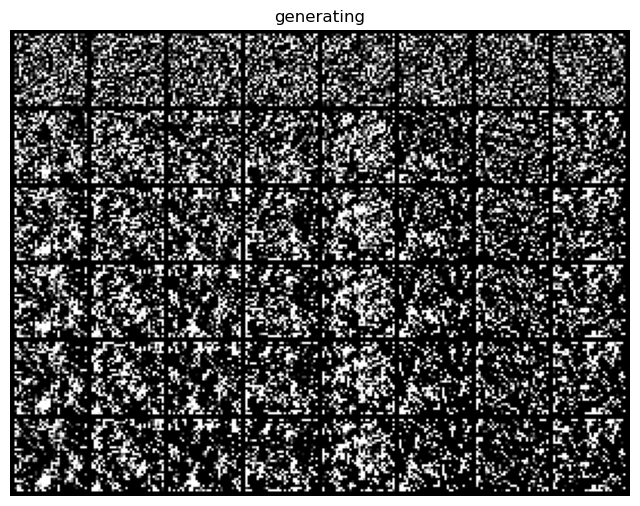

In [6]:
eps_model.eval()
print('sampling...')
class_ = torch.arange(8).to(DEVICE)
with torch.no_grad():
    x = torch.randn([8, IMAGE_CHANNEL, 32, 32], device=DEVICE)
    xt = torch.tensor([]).to(DEVICE)
    for t_ in tqdm(range(N_TIMESTAMPS)):
        t = N_TIMESTAMPS - t_ - 1
        t = x.new_full((1,), t, dtype=torch.long)
        x = diffusion.p_sample(x, t, class_)
        if t_ % 200 == 0 or t_ == N_TIMESTAMPS - 1:
            xt = torch.cat((xt, x))
    utils.draw_sample_image(xt, f"generating")

In [ ]:
dim = 256
half_dim = dim // 2
emb = math.log(10000) / (half_dim - 1)
emb = torch.exp(torch.arange(half_dim) * -emb)
plt.plot(emb)
plt.show()
        # emb = x[:, None] * emb[None, :]
        # emb = torch.cat((emb.sin(), emb.cos()), dim=-1)

In [ ]:
# not in use yet
class UNet(nn.Module):
    def __int__(self, in_channels):
        super().__init__()
        self.in_channels = in_channels
        self.down_conv_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=64,
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64,
                      kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.down_conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128,
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128,
                      kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.down_conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256,
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256,
                      kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.down_conv_4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512,
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.middle_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024,
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=1024,
                      kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.up_sample_4 = nn.ConvTranspose2d(
            in_channels=1024, out_channels=512, kernel_size=2, stride=2)
        self.up_sample_3 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256, kernel_size=2, stride=2)
        self.up_sample_2 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.up_sample_1 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.up_conv_1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64,
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64,
                      kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.up_conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128,
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128,
                      kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.up_conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256,
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256,
                      kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.up_conv_4 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512,
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.final_conv = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)

    def forward(self, x):
        c, h, w = x.shape
        assert c == self.in_channels

        # level 1
        x = self.down_conv_1(x)
        pass_through_1 = x
        x = F.max_pool2d(x, kernel_size=2)

        # level 2
        x = self.down_conv_2(x)
        pass_through_2 = x
        x = F.max_pool2d(x, kernel_size=2)

        # level 3
        x = self.down_conv_3(x)
        pass_through_3 = x
        x = F.max_pool2d(x, kernel_size=2)

        # level 4
        x = self.down_conv_4(x)
        pass_through_4 = x
        x = F.max_pool2d(x, kernel_size=2)
        assert x.shape[2] == 512

        # level 5
        x = self.middle_conv(x)

        # level 4
        x = self.up_sample_4(x)
        pass_through_4 = torchvision.transforms.functional.center_crop(
            pass_through_4, [x.shape[2], x.shape[3]])  # why? shape[2] and shape[3]?
        x = torch.cat([x, pass_through_4], dim=1)
        x = self.up_conv_4(x)

        # level 3
        x = self.up_sample_3(x)
        pass_through_3 = torchvision.transforms.functional.center_crop(
            pass_through_3, [x.shape[2], x.shape[3]])
        x = torch.cat([x, pass_through_3], dim=1)
        x = self.up_conv_3(x)

        # level 2
        x = self.up_sample_2(x)
        pass_through_2 = torchvision.transforms.functional.center_crop(
            pass_through_2, [x.shape[2], x.shape[3]])
        x = torch.cat([x, pass_through_2], dim=1)
        x = self.up_conv_2(x)

        # level 1
        x = self.up_sample_1(x)
        pass_through_1 = torchvision.transforms.functional.center_crop(
            pass_through_1, [x.shape[2], x.shape[3]])
        x = torch.cat([x, pass_through_1], dim=1)
        x = self.up_conv_1(x)

        x = self.final_conv(x)
        return x

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


class ConvBlock(nn.Conv2d):
    """
        Conv2D Block
            Args:
                x: (N, C_in, H, W)
            Returns:
                y: (N, C_out, H, W)
    """

    def __init__(self, in_channels, out_channels, kernel_size, activation_fn=None, drop_rate=0.,
                 stride=1, padding='same', dilation=1, groups=1, bias=True, gn=False, gn_groups=8):

        if padding == 'same':
            padding = kernel_size // 2 * dilation

        super(ConvBlock, self).__init__(in_channels, out_channels, kernel_size,
                                        stride=stride, padding=padding, dilation=dilation,
                                        groups=groups, bias=bias)

        self.activation_fn = nn.SiLU() if activation_fn else None
        self.group_norm = nn.GroupNorm(gn_groups, out_channels) if gn else None

    def forward(self, x, time_embedding=None, residual=False):

        if residual:
            # in the paper, diffusion timestep embedding was only applied to residual blocks of U-Net
            x = x + time_embedding
            y = x
            x = super(ConvBlock, self).forward(x)
            y = y + x
        else:
            y = super(ConvBlock, self).forward(x)
        y = self.group_norm(y) if self.group_norm is not None else y
        y = self.activation_fn(y) if self.activation_fn is not None else y

        return y


class Denoiser(nn.Module):

    def __init__(self, image_resolution, hidden_dims=[256, 256], diffusion_time_embedding_dim=256, n_times=1000):
        """
        image_resolution: example array [32, 32, 3]

        """
        super(Denoiser, self).__init__()

        _, _, img_C = image_resolution

        self.time_embedding = SinusoidalPosEmb(diffusion_time_embedding_dim)

        self.in_project = ConvBlock(img_C, hidden_dims[0], kernel_size=7)

        self.time_project = nn.Sequential(
            ConvBlock(diffusion_time_embedding_dim,
                      hidden_dims[0], kernel_size=1, activation_fn=True),
            ConvBlock(hidden_dims[0], hidden_dims[0], kernel_size=1))

        self.convs = nn.ModuleList([ConvBlock(
            in_channels=hidden_dims[0], out_channels=hidden_dims[0], kernel_size=3)])

        for idx in range(1, len(hidden_dims)):
            self.convs.append(ConvBlock(hidden_dims[idx-1], hidden_dims[idx], kernel_size=3, dilation=3**((idx-1)//2),
                                        activation_fn=True, gn=True, gn_groups=8))

        self.out_project = ConvBlock(
            hidden_dims[-1], out_channels=img_C, kernel_size=3)

    def forward(self, perturbed_x, diffusion_t):
        y = perturbed_x

        diffusion_embedding = self.time_embedding(diffusion_t)
        diffusion_embedding = self.time_project(
            diffusion_embedding.unsqueeze(-1).unsqueeze(-2))

        y = self.in_project(y)

        for i in range(len(self.convs)):
            y = self.convs[i](y, diffusion_embedding, residual=True)

        y = self.out_project(y)

        return y


model = Denoiser(image_resolution=IMG_SIZE,
                 hidden_dims=HIDDEN_DIMS,
                 diffusion_time_embedding_dim=TIMESTAMP_EMBED_DIM,
                 n_times=N_TIMESTAMPS).to(DEVICE)

In [ ]:
class Diffusion(nn.Module):
    def __init__(self, model, image_resolution=[32, 32, 3], n_times=1000, beta_minmax=[1e-4, 2e-2], device='cuda'):

        super(Diffusion, self).__init__()

        self.n_times = n_times
        self.img_H, self.img_W, self.img_C = image_resolution

        self.model = model

        # define linear variance schedule(betas)
        beta_1, beta_T = beta_minmax
        betas = torch.linspace(start=beta_1, end=beta_T, steps=n_times).to(
            device)  # follows DDPM paper
        self.sqrt_betas = torch.sqrt(betas)

        # define alpha for forward diffusion kernel
        self.alphas = 1 - betas
        self.sqrt_alphas = torch.sqrt(self.alphas)
        alpha_bars = torch.cumprod(self.alphas, dim=0)
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1-alpha_bars)
        self.sqrt_alpha_bars = torch.sqrt(alpha_bars)

        self.device = device

    def scale_to_minus_one_to_one(self, x):
        # according to the DDPMs paper, normalization seems to be crucial to train reverse process network
        return x * 2 - 1

    def reverse_scale_to_zero_to_one(self, x):
        return (x + 1) * 0.5

    def make_noisy(self, x_zeros, t):
        # perturb x_0 into x_t (i.e., take x_0 samples into forward diffusion kernels)
        epsilon = torch.randn_like(x_zeros).to(self.device)

        sqrt_alpha_bar = self.extract(self.sqrt_alpha_bars, t, x_zeros.shape)
        sqrt_one_minus_alpha_bar = self.extract(
            self.sqrt_one_minus_alpha_bars, t, x_zeros.shape)

        # Let's make noisy sample!: i.e., Forward process with fixed variance schedule
        #      i.e., sqrt(alpha_bar_t) * x_zero + sqrt(1-alpha_bar_t) * epsilon
        noisy_sample = x_zeros * sqrt_alpha_bar + epsilon * sqrt_one_minus_alpha_bar

        return noisy_sample.detach(), epsilon

    def forward(self, x_zeros):
        x_zeros = self.scale_to_minus_one_to_one(x_zeros)

        B, _, _, _ = x_zeros.shape

        # (1) randomly choose diffusion time-step
        t = torch.randint(low=0, high=self.n_times,
                          size=(B,)).long().to(self.device)

        # (2) forward diffusion process: perturb x_zeros with fixed variance schedule
        perturbed_images, epsilon = self.make_noisy(x_zeros, t)

        # (3) predict epsilon(noise) given perturbed data at diffusion-timestep t.
        pred_epsilon = self.model(perturbed_images, t)

        return perturbed_images, epsilon, pred_epsilon

    def denoise_at_t(self, x_t, timestep, t):
        B, _, _, _ = x_t.shape
        if t > 1:
            z = torch.randn_like(x_t).to(self.device)
        else:
            z = torch.zeros_like(x_t).to(self.device)

        # at inference, we use predicted noise(epsilon) to restore perturbed data sample.
        epsilon_pred = self.model(x_t, timestep)

        alpha = self.extract(self.alphas, timestep, x_t.shape)
        sqrt_alpha = self.extract(self.sqrt_alphas, timestep, x_t.shape)
        sqrt_one_minus_alpha_bar = self.extract(
            self.sqrt_one_minus_alpha_bars, timestep, x_t.shape)
        sqrt_beta = self.extract(self.sqrt_betas, timestep, x_t.shape)

        # denoise at time t, utilizing predicted noise
        x_t_minus_1 = 1 / sqrt_alpha * \
            (x_t - (1-alpha)/sqrt_one_minus_alpha_bar*epsilon_pred) + sqrt_beta*z

        return x_t_minus_1.clamp(-1., 1)

    def sample(self, N):
        # start from random noise vector, x_0 (for simplicity, x_T declared as x_t instead of x_T)
        x_t = torch.randn((N, self.img_C, self.img_H,
                          self.img_W)).to(self.device)

        # autoregressively denoise from x_T to x_0
        #     i.e., generate image from noise, x_T
        for t in range(self.n_times-1, -1, -1):
            timestep = torch.tensor([t]).repeat_interleave(
                N, dim=0).long().to(self.device)
            x_t = self.denoise_at_t(x_t, timestep, t)

        # denormalize x_0 into 0 ~ 1 ranged values.
        x_0 = self.reverse_scale_to_zero_to_one(x_t)

        return x_0


diffusion = Diffusion(model, image_resolution=IMG_SIZE, n_times=N_TIMESTAMPS,
                      beta_minmax=BETA_MIN_MAX, device=DEVICE).to(DEVICE)

optimizer = Adam(diffusion.parameters(), lr=LEARNING_RATE)
denoising_loss = nn.MSELoss()

In [ ]:

from torchsummary import summary

summary(diffusion, (1, 28, 28))



model.eval()
for batch_idx, (x, class_) in enumerate(train_loader):
    print(x.mean(), x.min(), x.max(), x.shape)
    x = x[:8].to(DEVICE)
    # perturbed_images, epsilon, pred_epsilon = diffusion(x)
    # perturbed_images = diffusion.reverse_scale_to_zero_to_one(perturbed_images)
    for t in range(0, N_TIMESTAMPS, 100):
        noisy_sample, _ = diffusion.make_noisy(
            x, torch.full((8, ), t).to(DEVICE))
        # print(f'{len(noisy_sample)}')
        # show_image(noisy_sample[0])
        draw_sample_image(noisy_sample, f"adding noise t={t}")
    break

# print(f'{len(perturbed_images)=}')
# show_image(perturbed_images[0])
# show_image(perturbed_images[1])
# show_image(perturbed_images[63])

In [ ]:
model.eval()

with torch.no_grad():
    generated_images = diffusion.sample(N=8)


In [ ]:
show_image(generated_images[0])

In [ ]:

# draw_sample_image(perturbed_images, "Perturbed Images")
draw_sample_image(generated_images, "Generated Images")
draw_sample_image(x[:8], "Ground-truth Images")


In [ ]:
from ignite.metrics import InceptionScore
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('1aurent/ddpm-mnist').to(DEVICE)
print(f'{pipeline.device}')

images = torch.tensor([])
for i in range(10):
    image_tensor = torchvision.transforms.functional.pil_to_tensor(pipeline().images[0])
    images = torch.cat((images, image_tensor))
    print(images.shape)

# metric = InceptionScore()
# metric.attach(default_evaluator, "is")
# y = torch.rand(10, 3, 299, 299)
# state = default_evaluator.run([y])
# print(state.metrics["is"])


In [ ]:
inception = InceptionScore()
# generate some images
# imgs = torch.randint(0, 255, (100, 3, 299, 299), dtype=torch.uint8)
# print(type(image))
for image in images:

    image_tensor = torchvision.transforms.functional.pil_to_tensor(image)
    print(f'{image_tensor.float().mean()=} {image_tensor.min()=} {image_tensor.max()=} {image_tensor.shape=}')
    # print(image_tensor)
    # print(image_tensor.expand(1, 3, 28, 28))
    expanded_image_tensor = image_tensor.expand(1, 3, 28, 28)
    # print(f'{expanded_image_tensor.shape}')
    inception.update(expanded_image_tensor)
    print(f'{inception.compute()=}')

In [ ]:
# inception = InceptionScore()
# imgs = torch.randint(0, 255, (64, 3, 32, 32), dtype=torch.uint8)
# inception.update(imgs)
# print(inception.compute())


pure_noise_is = InceptionScore()
cifar10_is = InceptionScore()
# train_batch_sample = list(train_loader)[0][0]
for batch_idx, (x, class_) in tqdm(enumerate(train_loader), total=len(train_loader)):
    cifar10_is.update(x)
    noise = torch.randint(0, 255, (64, 3, 32, 32), dtype=torch.uint8)
    pure_noise_is.update(noise)
    print(f'{pure_noise_is.compute()=} {cifar10_is.compute()=}')
# print(train_batch_sample)
# print(train_batch_sample.shape)

inception.compute()

In [ ]:
print(inception.compute())
fig_, ax_ = inception.plot()
fig_